In [24]:
import random
import numpy as np
import pandas as pd

import skimage

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from torchvision.models._utils import IntermediateLayerGetter

from models.modeling.deeplab import *
from dataloader.talk2car import *

import denseCRF
import pydensecrf.densecrf as dcrf

from PIL import Image
from skimage.transform import resize

from losses import Loss
from models.model import JointModel

from utils.im_processing import *

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
class Args:
    lr = 3e-4
    batch_size = 64
    num_workers = 4
    image_encoder = "deeplabv3_plus"
    num_layers = 1
    num_encoder_layers = 2
    dropout = 0.25
    skip_conn = False
    model_path = "./saved_model/talk2car/deeplabv3_plus_06_Jan_21-01.pth"
    loss = "bce"
    dataroot = "/ssd_scratch/cvit/kanishk/upload_annotations"
    glove_path = "/ssd_scratch/cvit/kanishk/glove/"
    dataset = "talk2car"
    task = "referit"
    split = "train"
    cache_type = "no_glove"
    seq_len = 20
    image_dim = 448
    mask_dim = 448
    corrected_spell = False


args = Args()

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()
print(f'{device} being used with {n_gpu} GPUs!!')

cuda being used with 2 GPUs!!


In [39]:
print("Initializing dataset")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
resize = transforms.Resize((args.image_dim, args.image_dim))

tokenizer = None

if args.dataset == "referit":
    val_dataset = ReferDataset(
        data_root=args.dataroot,
        dataset=args.task,
        transform=transforms.Compose([resize, to_tensor, normalize]),
        annotation_transform=transforms.Compose([ResizeAnnotation(args.mask_dim)]),
        split=args.split,
        max_query_len=args.seq_len,
        glove_path=args.glove_path,
    )
else:
    val_dataset = Talk2Car(
        root=args.dataroot,
        split=args.split,
        transform=transforms.Compose([resize, to_tensor, normalize]),
        mask_transform=transforms.Compose([ResizeAnnotation(args.mask_dim)]),
        glove_path=args.glove_path
    )

val_loader = DataLoader(
    val_dataset, shuffle=True, batch_size=1, num_workers=1, pin_memory=True
)

Initializing dataset


In [40]:
return_layers = {"layer2": "layer2", "layer3": "layer3", "layer4": "layer4"}

model = DeepLab(num_classes=21, backbone="resnet", output_stride=16)
model.load_state_dict(torch.load("./models/deeplab-resnet.pth.tar")["state_dict"])

image_encoder = IntermediateLayerGetter(model.backbone, return_layers)

for param in image_encoder.parameters():
    param.requires_grad_(False)

In [41]:
in_channels = 2048
out_channels = 512
stride = 2

joint_model = JointModel(
    in_channels=in_channels,
    out_channels=out_channels,
    stride=stride,
    num_layers=args.num_layers,
    num_encoder_layers=args.num_encoder_layers,
    dropout=args.dropout,
    skip_conn=args.skip_conn,
    mask_dim=args.mask_dim,
)

state_dict = torch.load(args.model_path)
if "state_dict" in state_dict:
    state_dict = state_dict["state_dict"]
joint_model.load_state_dict(state_dict) 

<All keys matched successfully>

In [42]:
if n_gpu > 1:
    image_encoder = nn.DataParallel(image_encoder)

joint_model.to(device)
image_encoder.to(device)

image_encoder.eval();
joint_model.eval();

In [43]:
loss_func = Loss(args)
val_iter = iter(val_loader)

In [44]:
def compute_mask_IOU(masks, target, thresh=0.3):
    assert(target.shape[-2:] == masks.shape[-2:])
    temp = ((masks>thresh) * target)
    intersection = temp.sum()
    union = (((masks>thresh) + target) - temp).sum()
    return intersection, union

def meanIOU(m, gt, t):
    temp = ((m > t)*gt)
    inter = temp.sum()
    union = ((m > t) + gt - temp).sum()
    return inter/union

### Example Visualization

In [45]:
val_iter = iter(val_loader)

(448, 448)
after passing that barrier make a turn to the right


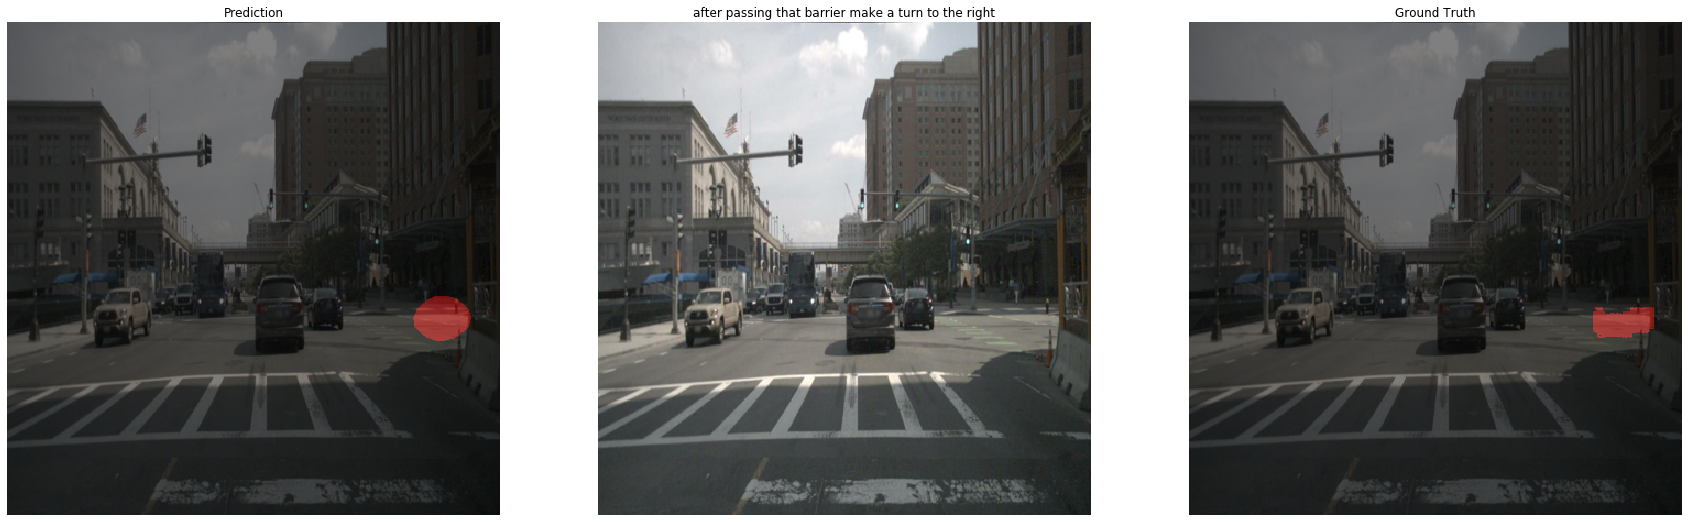

IOU overlab with ground truth: 0.6078323125839233, bestIOU: 0.6078323125839233


In [89]:
batch = val_iter.next()

img = batch["image"].cuda(non_blocking=True)

phrase = batch["phrase"].cuda(non_blocking=True)
phrase_mask = batch["phrase_mask"].cuda(non_blocking=True)

### Custom Phrase ###
# # batch["orig_phrase"] = "store on left next to hats blanket draped in front"
# phrase, phrase_mask = val_dataset.vocabulary.tokenize(batch["orig_phrase"])
# phrase = phrase.unsqueeze(0).cuda(non_blocking=True)
# phrase_mask = phrase_mask.unsqueeze(0).cuda(non_blocking=True)

gt_mask = batch["seg_mask"]
gt_mask = gt_mask.squeeze(dim=1)


batch_size = img.shape[0]
img_mask = torch.ones(batch_size, 14 * 14, dtype=torch.int64).cuda(non_blocking=True)

with torch.no_grad():
    img = image_encoder(img)  # ['out']

output_mask = joint_model(img, phrase, img_mask, phrase_mask)

output_mask = output_mask.detach().cpu()
mask_out = output_mask[0]

loss = loss_func(output_mask, gt_mask).item()
inter, union = compute_mask_IOU(output_mask, gt_mask)
    
score = inter / union

orig_image = batch["orig_image"].numpy()
orig_phrase = batch["orig_phrase"]


# orig_mask = batch["orig_mask"]/

example = {
    "image": orig_image,
    "phrase": orig_phrase,
    "mask_gt": gt_mask,
    "mask_pred": output_mask,
    # "orig_mask": orig_mask,
}

image = example["image"][0]
phrase = example["phrase"]
mask_gt = example["mask_gt"][0]
mask_pred = example["mask_pred"][0]

# im = (image * 255).astype('uint8')
im = image

iou = []
thr = []
cum_sum = []

t_ = 0.0

best_t = t_
best_iou = 0

while t_ < 1:
    miou = meanIOU(output_mask, gt_mask, t_)
    cum_sum.append((output_mask > t_).sum())
    iou.append(miou)
    thr.append(t_)
    
    if best_iou < miou:
        best_iou = miou
        best_t = t_
    
    t_ += 0.05

if best_t == 0:
    best_t += 0.01

im_seg = im[:] / 2
predicts = (mask_pred > best_t).numpy()
print(predicts.shape)
im_seg[:, :, 0] += predicts.astype('uint8') * 100
im_seg = im_seg.astype('uint8')

im_gt = im[:] / 2
gt = (mask_gt > 0).numpy()
im_gt[:, :, 0] += gt.astype('uint8') * 100
im_gt = im_gt.astype('uint8')

print(phrase[0])

figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 30))

axes[0].imshow(im_seg)
axes[0].set_title("Prediction")
axes[0].axis("off")

# image = batch["image"][0].permute(1, 2, 0).numpy()

axes[1].imshow(im)
axes[1].set_title(phrase[0], loc='center', wrap=True)
axes[1].axis("off")

axes[2].imshow(im_gt)
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.show()
print(f"IOU overlab with ground truth: {score}, bestIOU: {best_iou}")

### IoU and Result Evaluation

In [ ]:
img = batch["image"].cuda(non_blocking=True)

phrase = batch["phrase"].cuda(non_blocking=True)
phrase_mask = batch["phrase_mask"].cuda(non_blocking=True)

# ### Custom Phrase ###
# # batch["orig_phrase"] = "plant or frog not dark area"
# phrase, phrase_mask = val_dataset.tokenize_phrase(batch["orig_phrase"])
# phrase = phrase.unsqueeze(0).cuda(non_blocking=True)
# phrase_mask = phrase_mask.unsqueeze(0).cuda(non_blocking=True)

gt_mask = batch["seg_mask"]
gt_mask = gt_mask.squeeze(dim=1)


batch_size = img.shape[0]
img_mask = torch.ones(batch_size, 14 * 14, dtype=torch.int64).cuda(non_blocking=True)

with torch.no_grad():
    img = image_encoder(img)  # ['out']

output_mask = joint_model(img, phrase, img_mask, phrase_mask)

output_mask = output_mask.detach().cpu()

loss = loss_func(output_mask, gt_mask).item()
inter, union = compute_mask_IOU(output_mask, gt_mask)
    
score = inter / union

orig_image = batch["orig_image"].numpy()
orig_phrase = batch["orig_phrase"]
# orig_mask = batch["orig_mask"]/

example = {
    "image": orig_image,
    "phrase": orig_phrase,
    "mask_gt": gt_mask,
    "mask_pred": output_mask,
    # "orig_mask": orig_mask,
}

In [ ]:
image = example["image"][0]
phrase = example["phrase"]
mask_gt = example["mask_gt"][0]
mask_pred = example["mask_pred"][0]

In [ ]:
iou = []
thr = []
cum_sum = []

t_ = 0.0

best_t = t_
best_iou = 0

while t_ < 1:
    miou = meanIOU(output_mask, gt_mask, t_)
    cum_sum.append((output_mask > t_).sum())
    iou.append(miou)
    thr.append(t_)
    
    if best_iou < miou:
        best_iou = miou
        best_t = t_
    
    t_ += 0.05

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].plot(thr, iou)
ax[0].set_title('Threshold')
ax[0].grid(True)

ax[1].plot(thr, cum_sum)
ax[1].set_title('Cumulative Sum')
ax[1].grid(True)

In [ ]:
print(f'mean: {output_mask.mean():.4f}, max: {output_mask.max():.4f}, bestIOU: {best_iou}, best_thresh: {best_t:.2f}')

In [ ]:
# im = (image * 255).astype('uint8')
im = image

if best_t == 0:
    best_t += 0.01

im_seg = im[:] / 2
predicts = (mask_pred > best_t).numpy()
im_seg[:, :, 0] += predicts.astype('uint8') * 100
im_seg = im_seg.astype('uint8')

im_gt = im[:] / 2
gt = (mask_gt > 0).numpy()
im_gt[:, :, 0] += gt.astype('uint8') * 100
im_gt = im_gt.astype('uint8')

In [ ]:
print(phrase)

figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))

axes[0].imshow(im_seg)
axes[0].set_title("Prediction")
axes[0].axis("off")

axes[1].imshow(im)
axes[1].set_title(phrase, loc='center', wrap=True)
axes[1].axis("off")

axes[2].imshow(im_gt)
axes[2].set_title("Ground Truth")
axes[2].axis("off")

# axes[3].imshow(mask_gt)
# axes[3].set_title("Original Ground Truth")
# axes[3].axis("off")

plt.show()
print(f"IOU overlab with ground truth: {score}, bestIOU: {best_iou}")

### Dense CRF

In [ ]:
proc_im = skimage.img_as_ubyte(orig_image)[0]

H, W = proc_im.shape[:-1]

sigma_val = output_mask

d = dcrf.DenseCRF2D(H, W, 2)

U = np.expand_dims(-np.log(sigma_val), axis=0)
U_ = np.expand_dims(-np.log(1 - sigma_val), axis=0)

unary = np.concatenate((U_, U), axis=0)
unary = unary.reshape((2, -1))
d.setUnaryEnergy(unary)

# d.addPairwiseGaussian(sxy=5, compat=10)
# d.addPairwiseBilateral(sxy=20, srgb=3, rgbim=proc_im, compat=5)

d.addPairwiseGaussian(sxy=3, compat=5)
d.addPairwiseBilateral(sxy=5, srgb=5, rgbim=proc_im, compat=10)

# d.addPairwiseGaussian(sxy=3, compat=5)
# d.addPairwiseBilateral(sxy=10, srgb=3, rgbim=proc_im, compat=10)

Q = d.inference(5)

pred_raw_dcrf = np.argmax(Q, axis=0).reshape((H, W)).astype(np.float32)
dcrf_output_mask = torch.from_numpy(pred_raw_dcrf)

inter_dcrf, union_dcrf = compute_mask_IOU(dcrf_output_mask, gt_mask)
score_dcrf = inter_dcrf/union_dcrf

im_seg_dcrf = im[:] / 2
predicts = dcrf_output_mask.numpy()
im_seg_dcrf[:, :, 0] += predicts.astype('uint8') * 100
im_seg_dcrf = im_seg_dcrf.astype('uint8')

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))

axes[0].imshow(im_seg_dcrf)
axes[0].set_title("DCRF Prediction")
axes[0].axis("off")

axes[1].imshow(proc_im)
axes[1].set_title(phrase, loc='center', wrap=True)
axes[1].axis("off")

axes[2].imshow(im_gt)
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.show()

print(f'IOU with dcrf output: {score_dcrf}')

### Simple CRF

In [ ]:
proc_im = skimage.img_as_ubyte(orig_image)[0]
sigma_val = output_mask


mask_pred = np.stack([1 - sigma_val[0], sigma_val[0]], axis=2)
param = (10, 20, 3, 5, 3, 5)

simple_crf_out = denseCRF.densecrf(proc_im, mask_pred, param) 
simple_crf_mask = torch.from_numpy(simple_crf_out)

inter_sdcrf, union_sdcrf = compute_mask_IOU(simple_crf_mask, gt_mask)
score_sdcrf = inter_sdcrf/union_sdcrf

im_seg_sdcrf = im[:] / 2
predicts = simple_crf_mask.numpy()
im_seg_sdcrf[:, :, 0] += predicts.astype('uint8') * 100
im_seg_sdcrf = im_seg_sdcrf.astype('uint8')

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))

axes[0].imshow(im_seg_sdcrf)
axes[0].set_title("Simple DCRF Prediction")
axes[0].axis("off")

axes[1].imshow(image)
axes[1].set_title(phrase, loc='center', wrap=True)
axes[1].axis("off")

axes[2].imshow(im_gt)
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.show()

print(f'IOU with simple dcrf output: {score_sdcrf}')

### Overall IOU Calculation

In [ ]:
out_max = []
best_ts = []

overall_iou_t = [0 for _ in range(20)]

inter_t = [0 for _ in range(20)]
union_t = [0 for _ in range(20)]

t_inter, t_union = 0, 0

for step, batch in enumerate(val_loader):

    img = batch["image"].cuda(non_blocking=True)
    phrase = batch["phrase"].cuda(non_blocking=True)
    phrase_mask = batch["phrase_mask"].cuda(non_blocking=True)

    gt_mask = batch["seg_mask"]
    gt_mask = gt_mask.squeeze(dim=1)

    batch_size = img.shape[0]
    img_mask = torch.ones(batch_size, 14 * 14, dtype=torch.int64).cuda(non_blocking=True)

    with torch.no_grad():
        img = image_encoder(img)  # ['out']

    output_mask = joint_model(img, phrase, img_mask, phrase_mask)

    output_mask = output_mask.detach().cpu()
    
    inter, union = compute_mask_IOU(output_mask, gt_mask, 0.5)
    
    t_inter += inter
    t_union += union

    t_ = 0.0

    best_t = t_
    best_iou = 0

    for i in range(20):
        m_iou = meanIOU(output_mask, gt_mask, t_)
        
        inter_, union_ = compute_mask_IOU(output_mask, gt_mask, t_)
        
        inter_t[i] += inter_.item()
        union_t[i] += union_.item()

        if best_iou < m_iou:
            best_iou = m_iou
            best_t = t_

        t_ += 0.05
    
    if step % 500 == 0:
        print(f'step: {step} bestIOU: {best_iou}, best_thresh: {best_t:.2f}')
    
    out_max.append(output_mask.max().item())
    best_ts.append(best_t)

overall_iou = t_inter/t_union
print(f'overall IOU: {overall_iou}')

In [ ]:
overall_IOU = [inter_t[i]/union_t[i] for i in range(20)]
x = [i*0.05 for i in range(20)]

In [ ]:
df = pd.DataFrame(data=overall_IOU, index=x, columns=['IOU']).sort_values(by='IOU')
print(df)

In [ ]:
plt.plot(x, overall_IOU)
plt.grid(True)

In [ ]:
ts = [a for a in best_ts]

count = {}
for t in ts:
    if t not in count:
        count[t] = 0
    count[t] += 1
x,y = count.keys(), count.values()
    
plt.scatter(x, y)
plt.grid(True)

## Threshold Calculation

In [ ]:
gt = torch.tensor([1])

In [ ]:
network = nn.Sequential(nn.Linear(56*56, 100), nn.ReLU(), nn.Linear(100, 20), nn.Softmax(dim=-1))

In [ ]:
optim = torch.optim.Adam(network.parameters(), 1e-3)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
output_mask.shape

In [ ]:
network.train()
for _ in range(10):
    t = network(output_mask.flatten(1))
    
    loss = criterion(t, gt)
 
    optim.zero_grad()
    loss.backward()
    optim.step()

In [ ]:
network.eval()

t = network(output_mask.flatten(1))
thresh = t.argmax(dim=-1)*0.05

final_cost = meanIOU(output_mask, gt_mask, thresh)
print(final_cost)

## POC threshold

In [ ]:
data_len = len(val_loader)
train_data, test_data = torch.utils.data.random_split(
    val_dataset, [5000, data_len - 5000], generator=torch.Generator().manual_seed(42)
)

In [ ]:
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=32, num_workers=4, pin_memory=True
)

test_loader = DataLoader(
    test_data, shuffle=True, batch_size=1, num_workers=1, pin_memory=True
)

In [ ]:
network = nn.Sequential(
    nn.ReLU(),
    nn.Conv2d(1, 10, 3, 2, 1),
    nn.ReLU(),
    nn.Conv2d(10, 10, 3, 1, 1),
    nn.ReLU(),
    nn.Conv2d(10, 5, 3, 2, 1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(196 * 5, 100),
    nn.ReLU(),
    nn.Linear(100, 20),
    nn.Sigmoid(),
).cuda()
optim = torch.optim.AdamW(network.parameters(), 0.01)

In [ ]:
criterion = nn.BCELoss()

In [ ]:
def compute_IOU(masks, target, thresh=0.3):
    assert(target.shape[-2:] == masks.shape[-2:])
    temp = ((masks>thresh) * target)
    intersection = torch.sum(temp.flatten(1), dim=-1, keepdim=True)
    union = torch.sum((((masks>thresh) + target) - temp).flatten(1), dim=-1, keepdim=True)
    return intersection, union

In [ ]:
network.train()

total_epochs = 5

train_len = len(train_loader)
for epoch in range(total_epochs):
    epoch_loss = 0
    for idx, batch in enumerate(train_loader):
        with torch.no_grad():
            img = batch["image"].cuda(non_blocking=True)
            phrase = batch["phrase"].cuda(non_blocking=True)
            phrase_mask = batch["phrase_mask"].cuda(non_blocking=True)

            gt_mask = batch["seg_mask"].cuda(non_blocking=True)
            gt_mask = gt_mask.squeeze(dim=1)

            batch_size = img.shape[0]
            img_mask = torch.ones(batch_size, 14 * 14, dtype=torch.int64).cuda(non_blocking=True)

            with torch.no_grad():
                img = image_encoder(img) 

            output_mask = joint_model(img, phrase, img_mask, phrase_mask)

        ious = torch.zeros(batch_size, 20)
        for i in range(20):
            thresh = i*0.05
            inter, union = compute_IOU(output_mask, gt_mask, thresh)
            m_iou = (inter/union).squeeze()
            ious[:, i] = m_iou
        _, ind = torch.topk(ious, k=5, dim=-1)
        ind = ind.cuda()
        gt_truth = torch.zeros(batch_size, 20).cuda()
        gt_truth.scatter_(1, ind, 1)
        
        thresh_out = network(output_mask.unsqueeze(1))

        loss = criterion(thresh_out, gt_truth)

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_loss += loss.item()

        if idx % 50 == 0:
            print(f'Epoch: [{epoch}/{total_epochs}] step: [{idx:3d}/{train_len}], loss: {epoch_loss/(idx + 1):.4f}')

    epoch_loss = epoch_loss/(idx+1)
    print(f'Epoch: [{epoch}/{total_epochs}] train_loss: {epoch_loss}')

In [ ]:
network.eval()
data_len = len(test_loader)

thresh_inter, thresh_union = 0, 0
fix_inter, fix_union = 0, 0

for idx, batch in enumerate(test_loader):
    with torch.no_grad():
        img = batch["image"].cuda(non_blocking=True)
        phrase = batch["phrase"].cuda(non_blocking=True)
        phrase_mask = batch["phrase_mask"].cuda(non_blocking=True)

        gt_mask = batch["seg_mask"].cuda(non_blocking=True)
        gt_mask = gt_mask.squeeze(dim=1)

        batch_size = img.shape[0]
        img_mask = torch.ones(batch_size, 14 * 14, dtype=torch.int64).cuda(non_blocking=True)

        with torch.no_grad():
            img = image_encoder(img) 

        output_mask = joint_model(img, phrase, img_mask, phrase_mask)

    ious = torch.zeros(batch_size, 20)
    for i in range(20):
        thresh = i*0.05
        inter, union = compute_IOU(output_mask, gt_mask, thresh)
        m_iou = (inter/union).squeeze()
        ious[:, i] = m_iou
    _, ind = torch.topk(ious, k=3, dim=-1)
    ind = ind.cuda()
    gt_truth = torch.zeros(batch_size, 20).cuda()
    gt_truth.scatter_(1, ind, 1)

    thresh_out = network(output_mask.unsqueeze(1))
    
    thresh = 0.05*thresh_out.argmax(dim=-1)[:, None, None]
    inter, union = compute_mask_IOU(output_mask, gt_mask, thresh)
    
    thresh_inter += inter
    thresh_union += union
    
    inter_, union_ = compute_mask_IOU(output_mask, gt_mask, 0.3)
    
    fix_inter += inter_
    fix_union += union_
    
    thresh_iou = thresh_inter/thresh_union
    fix_iou = fix_inter/fix_union
    
    if idx%50 == 0:
        print(f'[{idx}/{data_len}] thresh_IOU: {thresh_iou:.4f}, fix_IOU: {fix_iou:.4f}')